In [55]:
from gensim import corpora, models
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import random
import numpy as np
from datasets import load_dataset
from collections import Counter
import pandas as pd

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Timur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Timur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
SEED_VALUE = 42 


random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [57]:
def retrieve_data(max_length=30):
    dataset = load_dataset("wmt14", "de-en")

    raw_subset = dataset["train"].select(range(200000))

    def is_short(example):
        return len(example["translation"]["de"].split()) <= max_length and \
               len(example["translation"]["en"].split()) <= max_length

    filtered = raw_subset.filter(is_short)

    train_data = filtered.select(range(50000))
    val_data = filtered.select(range(50000, 53000))
    test_data = filtered.select(range(53000, 56000))

    return {
        "train": train_data,
        "validation": val_data,
        "test": test_data
    }

In [58]:
def translated(n, model):
    return model.translate_text(n)

In [59]:
data = retrieve_data()

In [60]:
print(data["train"].shape)
print(data["test"].shape)
print(data["validation"].shape)

(50000, 1)
(3000, 1)
(3000, 1)


In [61]:
data["validation"]["translation"][:10]

[{'de': 'Herr Präsident, bei dieser Richtlinie über die Etikettierung von Rindfleisch und Rindfleischerzeugnissen geht es um zwei unterschiedliche Aspekte.',
  'en': 'Mr President, this legislation on the labelling of beef has two distinct aspects.'},
 {'de': 'Erstens wird dadurch die Rückverfolgbarkeit von Rindfleischerzeugnissen sichergestellt.',
  'en': 'Firstly it ensures traceability of beef products.'},
 {'de': 'Gelegentlich treten jedoch auch in Schottland Probleme, wie zum Beispiel ein Befall mit E-Coli-Bakterien, auf.',
  'en': 'Occasionally, however, there is a problem such as the E-coli outbreak in Scotland.'},
 {'de': 'Zweitens kann durch die Etikettierung festgestellt werden, aus welchem Land oder welchen Ländern das Rindfleisch stammt.',
  'en': 'Secondly, labelling will identify the country or countries of origin of beef.'},
 {'de': 'Durch die BSE-Krise sind die möglichen Gesundheitsgefahren in den Vordergrund gerückt, die durch den Verzehr von Rindfleisch auftreten könn

In [62]:

def preprocess(texts):
    stop_words = set(stopwords.words('english'))
    return [
        [word for word in word_tokenize(t.lower()) if word.isalpha() and word not in stop_words]
        for t in texts
    ]

train_texts = [ex["translation"]["en"] for ex in data["train"]]
test_texts = [ex["translation"]["en"] for ex in data["test"]]

train_tokens = preprocess(train_texts)
test_tokens = preprocess(test_texts)

dictionary = corpora.Dictionary(train_tokens + test_tokens)
train_corpus = [dictionary.doc2bow(text) for text in train_tokens]
test_corpus = [dictionary.doc2bow(text) for text in test_tokens]

lda = models.LdaModel(train_corpus, num_topics=6, id2word=dictionary, passes=10)


In [107]:


def topic_distribution(corpus, lda_model):
    topic_counts = Counter()
    for doc in corpus:
        topics = lda_model.get_document_topics(doc)
        if topics:
            top_topic = max(topics, key=lambda x: x[1])
            topic_counts[top_topic[0]] += 1
    return topic_counts

train_dist = topic_distribution(train_corpus, lda)
test_dist = topic_distribution(test_corpus, lda)

df_train = pd.DataFrame([
    {"Topic": f"Topic {k}", "Dataset": "Train", "Count": v}
    for k, v in train_dist.items()
] )

df_test = pd.DataFrame([
    {"Topic": f"Topic {k}", "Dataset": "Test", "Count": v}
    for k, v in test_dist.items()
])


In [108]:
df_train["Count_norm"] = round(df_train["Count"] / df_train["Count"].sum(), 2)

df_train.head()

,Topic,Dataset,Count,Count_norm
0,Topic 3,Train,13298,0.27
1,Topic 4,Train,7928,0.16
2,Topic 5,Train,8870,0.18
3,Topic 2,Train,8385,0.17
4,Topic 1,Train,6279,0.13


In [109]:
df_test["Count_norm"] = round(df_test["Count"] / df_test["Count"].sum(), 2)

df_test.head()

,Topic,Dataset,Count,Count_norm
0,Topic 4,Test,447,0.15
1,Topic 1,Test,419,0.14
2,Topic 3,Test,843,0.28
3,Topic 5,Test,582,0.19
4,Topic 0,Test,260,0.09


In [110]:
for i, topic in lda.print_topics(num_words=10):
    print(f"Topic {i}: {topic}")


Topic 0: 0.022*"commission" + 0.012*"amendments" + 0.011*"cooperation" + 0.011*"committee" + 0.010*"amendment" + 0.010*"years" + 0.010*"proposal" + 0.009*"therefore" + 0.008*"treaty" + 0.008*"proposed"
Topic 1: 0.068*"european" + 0.031*"union" + 0.020*"parliament" + 0.019*"council" + 0.013*"must" + 0.013*"rights" + 0.011*"presidency" + 0.009*"human" + 0.009*"common" + 0.009*"position"
Topic 2: 0.009*"euro" + 0.008*"market" + 0.007*"time" + 0.006*"procedure" + 0.006*"also" + 0.006*"think" + 0.006*"problem" + 0.006*"would" + 0.006*"good" + 0.006*"however"
Topic 3: 0.045*"mr" + 0.032*"president" + 0.025*"would" + 0.021*"like" + 0.018*"report" + 0.012*"parliament" + 0.011*"question" + 0.011*"debate" + 0.009*"mrs" + 0.008*"commissioner"
Topic 4: 0.021*"europe" + 0.015*"take" + 0.012*"countries" + 0.010*"people" + 0.009*"must" + 0.007*"place" + 0.007*"also" + 0.006*"one" + 0.006*"world" + 0.006*"health"
Topic 5: 0.022*"member" + 0.022*"states" + 0.018*"must" + 0.013*"also" + 0.010*"need" + 0

| Topic | Top Keywords (excerpt)                                    | Proposed Label                                                  |
|:-----:|:----------------------------------------------------------|:----------------------------------------------------------------|
| 0     | commission, amendments, cooperation, committee, amendment, years, proposal, therefore, treaty, proposed   | **EU Commission Actions**                      |
| 1     | european, union, parliament, council, must, rights, presidency, human, common, position         | **EU Structure**         |
| 2     | euro, market, time, procedure, also, think, problem, would, good, however         | **Economic**                    |
| 3     | mr, president, would, like, report, parliament, question, debate, mrs, commissioner     | **Formal Debates**                |
| 4     | 	europe, take, countries, people, must, place, also, one, world, health      | **Global & Social Affairs**              |
| 5     | member, states, must, also, need, commission, information, state, policy, national      | **Member States**        |


In [112]:
df_test = df_test.sort_values(by="Topic")
df_train = df_train.sort_values(by="Topic")

df_test["Topic"] = ["EU Commission Actions", "EU Structure", "Economic", "Formal Debates", "Global & Social Affairs", "Member States"]
df_train["Topic"] = ["EU Commission Actions", "EU Structure", "Economic", "Formal Debates", "Global & Social Affairs", "Member States"]

In [113]:
import matplotlib.pyplot as plt

import pandas as pd
import circlify
cmap = plt.get_cmap("Blues")  


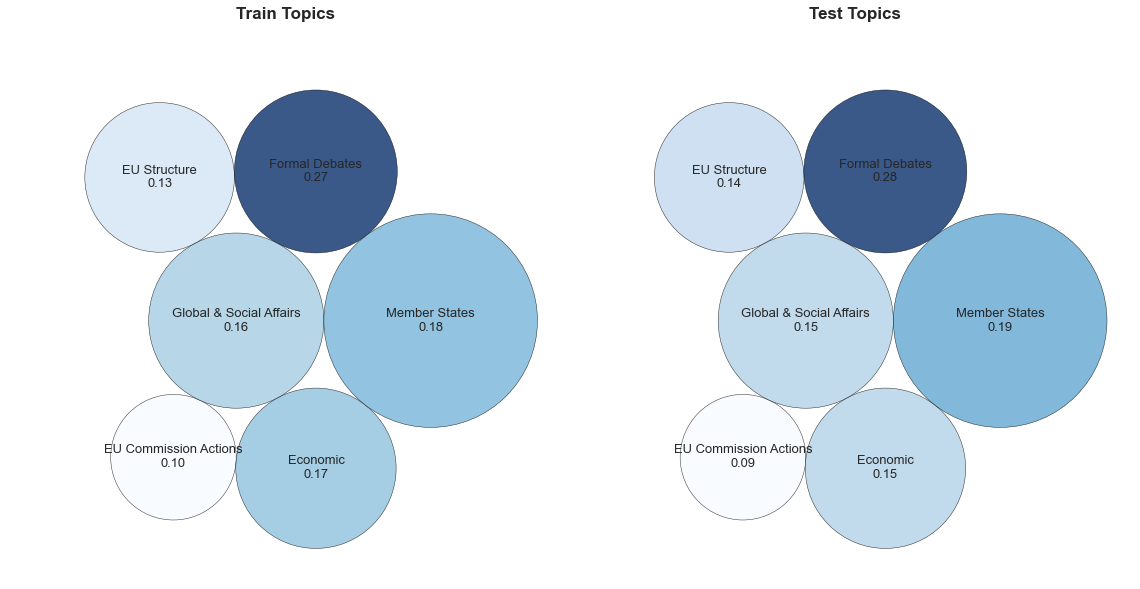

In [114]:

combined = pd.concat([df_train, df_test])
df_combined_counts = combined.groupby('Topic', as_index=False)['Count_norm'].sum()
sizes = df_combined_counts['Count_norm'].tolist()

base_circles = circlify.circlify(
    sizes, 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

def packed_bubble_fixed(ax, df, title,  base_circles, cmap='Blues'):
    df_counts = df.groupby('Topic', as_index=False)['Count_norm'].sum()
    df_counts['Label'] = df_counts['Topic']
    sizes = df_counts['Count_norm'].tolist()
    labels = df_counts['Label'].tolist()

    norm = plt.Normalize(min(sizes), max(sizes))
    cmap = plt.get_cmap(cmap)

    ax.set_title(title, fontsize=17, fontweight='bold')
    ax.axis('off')
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal')

    for circle, label, cnt in zip(base_circles, labels, sizes):
        x, y, r = circle.x, circle.y, circle.r
        color = cmap(norm(cnt))
        ax.add_patch(plt.Circle((x, y), r, alpha=0.8, color=color, ec='black', lw=0.5))
        ax.text(x, y, f"{label}\n{cnt:.2f}", ha='center', va='center', fontsize=13, wrap=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
packed_bubble_fixed(ax1, df_train, "Train Topics",  base_circles, cmap="Blues")
packed_bubble_fixed(ax2, df_test,  "Test Topics",   base_circles, cmap="Blues")
plt.tight_layout()
plt.show()


